# Cross probability model

All exploratory work for determining probability of a successful cross


### Reflection 

Given there is limited data for training, the model performance is not the best

Another issue is the abiguity of incomplete vs complete cross
- crosses can often be made into space 
- even though a cross is "incomplete", it doesn't mean the team can't regain possesion and now be in a more dangerous location 

With these considerations in mind, a better definition of incomplete vs complete may mean we end up with a more balanced dataset or better data labels for each cross

Also with a larger dataset the model may be able pick up more patterns, <1000 observations for each class is not ideal to train a accurate model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsbombpy import sb
from mplsoccer import Pitch, VerticalPitch

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## Collect all cross events 

In [3]:
matches = sb.matches(competition_id=55, season_id=43)
matches = matches[matches['match_status_360'] == 'available']
match_ids = matches.match_id.unique()
match_ids

array([3795220, 3788769, 3788761, 3788766, 3788764, 3788773, 3788755,
       3788754, 3788762, 3788760, 3788747, 3788741, 3795109, 3795187,
       3795108, 3788770, 3795506, 3794688, 3794692, 3794686, 3794687,
       3794685, 3788774, 3788771, 3788772, 3788768, 3788767, 3788753,
       3788765, 3788763, 3788759, 3788758, 3788757, 3788745, 3795107,
       3795221, 3794689, 3788746, 3794691, 3794690, 3788756, 3788749,
       3788750, 3788748, 3788751, 3788752, 3788742, 3788775, 3788776,
       3788743, 3788744])

In [4]:
# collect all passing events 
cols = ['teammate', 'actor', 'location_x', 'id',
           'player', 'position', 'team', 'type', 'timestamp', 
           'pass_end_location', 'pass_length', 'pass_height',
           'pass_outcome', 'pass_recipient', 'pass_cross', 'interception_outcome',
           'pass_aerial_won', 'pass_technique', 'play_pattern']

cross_df = pd.DataFrame(columns=cols)

matches = sb.matches(competition_id=55, season_id=43)
match_ids = matches[matches['match_status_360'] == 'available'].match_id.unique()

for match_id in tqdm(match_ids):
    
    events = sb.events(match_id=match_id)
    match_frames = sb.frames(match_id=match_id, fmt='dataframe')

    # join the events to the frames 
    df = pd.merge(match_frames, events, left_on='id', right_on='id', how='left')
    
    # take relevant cols 
    df = df[cols]

    # filter for crosses only
    df = df[df['pass_cross'] == True]

    # append to overall df
    cross_df = cross_df.append(df)

len(cross_df.id.unique())

100%|██████████| 51/51 [03:15<00:00,  3.83s/it]


1016

In [5]:
cross_df[cross_df['pass_outcome'] == 'Incomplete'].pass_end_location

4977     [107.9, 31.6]
4978     [107.9, 31.6]
4979     [107.9, 31.6]
4980     [107.9, 31.6]
4981     [107.9, 31.6]
             ...      
34875    [109.3, 38.9]
34876    [109.3, 38.9]
34877    [109.3, 38.9]
34878    [109.3, 38.9]
34879    [109.3, 38.9]
Name: pass_end_location, Length: 9263, dtype: object

In [4]:
cross_df.pass_aerial_won.value_counts()

True    125
Name: pass_aerial_won, dtype: int64

In [5]:
cross_df.pass_technique.value_counts()

Through Ball    170
Name: pass_technique, dtype: int64

In [6]:
cross_df.pass_height.value_counts()

High Pass      11027
Ground Pass     2463
Low Pass        2163
Name: pass_height, dtype: int64

majority of passes are made high in the air

In [7]:
cross_df.pass_outcome.value_counts()

Incomplete          9263
Out                  880
Unknown              310
Pass Offside          49
Injury Clearance      21
Name: pass_outcome, dtype: int64

## Generate freeze frames for each cross event 

Similar to the freeze frames provided for shots

In [8]:
data_freeze_frame = pd.DataFrame()
outcomes = []
locations = []
end_locations = []
lengths = []
heights = []
freeze_frames=  []

for i in cross_df.id.unique():
    df = cross_df[cross_df['id'] == i]
    
    frame = []
    for id,row in df.iterrows():
        if row.actor == True:
            outcomes.append(row.pass_outcome)
            locations.append(row.location_x)
            end_locations.append(row.pass_end_location)
            lengths.append(row.pass_length)
            heights.append(row.pass_height)
        else:
            freeze_frame = {}
            freeze_frame['location'] = row.location_x
            freeze_frame['player'] = {'name': row.player}
            freeze_frame['position'] = {'name': row.position}
            freeze_frame['teammate'] = row.teammate
            frame.append(freeze_frame)
    freeze_frames.append(frame)
        
data_freeze_frame['location'] = locations
data_freeze_frame['pass_end_location'] = end_locations
data_freeze_frame['pass_length'] = lengths
data_freeze_frame['pass_height'] = heights
data_freeze_frame['freeze_frame'] = freeze_frames
data_freeze_frame['outcome'] = outcomes

In [9]:
# split locations into x and y
data_freeze_frame[['loc_x', 'loc_y']] = data_freeze_frame['location'].apply(pd.Series)
data_freeze_frame[['cross_end_loc_x', 'cross_end_loc_y']] = data_freeze_frame['pass_end_location'].apply(pd.Series)
data_freeze_frame = data_freeze_frame[['loc_x', 'loc_y', 'cross_end_loc_x', 'cross_end_loc_y', 'pass_length', 'pass_height', 'freeze_frame', 'outcome']]

In [10]:
data_freeze_frame.head()

,loc_x,loc_y,cross_end_loc_x,cross_end_loc_y,pass_length,pass_height,freeze_frame,outcome
0,100.32713,14.455826,107.9,31.6,24.667793,Ground Pass,"[{'location': [84.70584, 39.23412], 'player': ...",Incomplete
1,100.88759,66.107300,115.1,35.0,39.924930,Low Pass,"[{'location': [92.973495, 49.535145], 'player'...",Incomplete
2,105.85606,52.998516,102.7,48.9,11.301770,Ground Pass,"[{'location': [93.57571, 42.95422], 'player': ...",NaN
3,106.64377,15.899750,118.8,38.5,25.492155,High Pass,"[{'location': [94.62771, 24.104874], 'player':...",Incomplete
4,111.54828,10.868190,108.5,40.4,30.112455,High Pass,"[{'location': [98.72852, 16.362564], 'player':...",Incomplete


# Exploration of transition probabilities 

Probability of cross made from zone i to j

For simplicity, divide into 6 zones: right box (RB), middle box (MB), left box (LB), top of box (TOB) and far side (right (RF) and left flank (LF), mostly where the crosses will be made from)

In [11]:
def section(x,y):
    if (x <= 60 and y <= 18) or (x >= 60 and y >= 62):
        return 'RF'
    elif (x <= 60 and y >= 62) or (x >= 60 and y <= 18):
        return 'LF'
    elif (x <= 18 and 18 <= y <= 30) or (x >= 102 and 50 <= y <= 62):
        return 'RB'
    elif (x <= 18 and 30 <= y <= 50) or (x >= 102 and 30 <= y <= 50):
        return 'MB'
    elif (x <= 18 and 50 <= y <= 62) or (x >= 102 and 18 <= y <= 30):
        return 'LB'
    elif (18 <= x <= 60 and 18 <= y <= 62) or (60 <= x <= 102 and 18 <= y <= 62):
        return 'TOB'

In [12]:
mapping = {'RF': 0,
          'LF': 1,
          'RB': 2,
          'MB': 3,
          'LB': 4,
          'TOB': 5}

In [13]:
# counts of crosses from i to j 
counts = [[0]*6, [0]*6, [0]*6, [0]*6, [0]*6, [0]*6]

In [14]:
for id, row in data_freeze_frame.iterrows():
    # cross section 
    cross_section = section(row.loc_x, row.loc_y)

    # end section 
    end_section = section(row.cross_end_loc_x, row.cross_end_loc_y)

    i = mapping[cross_section]
    j = mapping[end_section]
    counts[i][j] = counts[i][j] + 1

In [15]:
counts

[[0, 25, 2, 318, 34, 2],
 [26, 0, 38, 264, 0, 3],
 [0, 6, 2, 107, 5, 1],
 [0, 0, 0, 1, 0, 0],
 [4, 0, 6, 113, 0, 3],
 [3, 1, 4, 42, 6, 0]]

In [16]:
# Calculate probs 
p = [[0]*6, [0]*6, [0]*6, [0]*6, [0]*6, [0]*6]

for i in range(len(counts)):
    for j in range(len(counts)):
        p[i][j] = round(counts[i][j] / sum(counts[i]),4)

p

[[0.0, 0.0656, 0.0052, 0.8346, 0.0892, 0.0052],
 [0.0785, 0.0, 0.1148, 0.7976, 0.0, 0.0091],
 [0.0, 0.0496, 0.0165, 0.8843, 0.0413, 0.0083],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0317, 0.0, 0.0476, 0.8968, 0.0, 0.0238],
 [0.0536, 0.0179, 0.0714, 0.75, 0.1071, 0.0]]

## Extract additional features

From research, Statsbomb has concluded that the radius of pressure is roughly 2.3 yards ~= 3 yards.

"That means the pressure radius is on average only, 2.3 yards"

https://statsbomb.com/articles/soccer/shots-under-pressure-part-2-headers/

When determining pressure on a cross, we will look at players within 3 yards of the actor

In [17]:
pass_height_mapping = {'High Pass': 0,
                'Ground Pass': 1,
                'Low Pass': 2 }

In [18]:
outcomes = []
origin_sections = []
destination_sections = []
opp_in_dest = []
tm_in_dest = []
pressures = []
pass_heights = []

for id, row in data_freeze_frame.iterrows():
    if row.outcome in ['Incomplete', 'Out']: outcomes.append(0)
    else: outcomes.append(1)
       
    cross_x = row.loc_x
    cross_y = row.loc_y
    
    destination = section(row.cross_end_loc_x, row.cross_end_loc_y)

    origin_sections.append(mapping[section(cross_x, cross_y)])
    destination_sections.append(mapping[destination])
    pass_heights.append(pass_height_mapping[row.pass_height])
    
    opp_count = 0
    tm_count = 0
    pressure = 0
    
    for player in row.freeze_frame:
        player_x = player['location'][0]
        player_y = player['location'][1]
        
        #count how many opponents are within 3 yards of player making the cross
        if ((cross_x - player_x)**2 + (cross_y - player_y)**2) <= 3**2 and (player['teammate'] == False) and (player['position']['name'] != 'Goalkeeper'):
            pressure += 1
        
        # count of teammates in cross destination zone
        if player['teammate'] == True:
            if section(player_x, player_y) == destination:
                tm_count+=1
                
        # count of opponents in cross destination zone
        else:
            if section(player_x, player_y) == destination:
                opp_count+=1
                
    opp_in_dest.append(opp_count)
    tm_in_dest.append(tm_count)
    pressures.append(pressure)
            
    
data_freeze_frame['outcome'] = outcomes
data_freeze_frame['cross_origin'] = origin_sections
data_freeze_frame['cross_dest'] = destination_sections
data_freeze_frame['zone_pressure'] = opp_in_dest # num opp in dest zone
data_freeze_frame['zone_support'] = tm_in_dest # num teammates in dest zone 
data_freeze_frame['cross_pressure'] = pressures # num of opp on crosser
data_freeze_frame['cross_height'] = pass_heights


In [19]:
data = data_freeze_frame[['loc_x', 'loc_y', 'cross_dest', 'cross_origin', 'zone_pressure', 'zone_support', 'pass_length', 'cross_height', 'cross_pressure', 'outcome']]

data.head()

,loc_x,loc_y,cross_dest,cross_origin,zone_pressure,zone_support,pass_length,cross_height,cross_pressure,outcome
0,100.32713,14.455826,3,1,5,1,24.667793,1,0,0
1,100.88759,66.107300,3,0,2,0,39.924930,2,0,0
2,105.85606,52.998516,3,2,3,0,11.301770,1,2,1
3,106.64377,15.899750,3,1,6,2,25.492155,0,0,0
4,111.54828,10.868190,3,1,6,3,30.112455,0,1,0


## Modelling

Classification model to predict if a cross will be successful or not

Can then be used to predict the probability of success for each cross (rather than binary decision)

Logistic regression was selected for its interpretability and ease of use

Also performed better compared to tree based models such as XGBoost

In [20]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score, accuracy_score

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [21]:
# train test split
X = data[['loc_y', 'cross_dest', 'zone_pressure', 'zone_support', 'cross_pressure']]
y = data['outcome']

train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2,random_state=45,stratify=y)

In [22]:
data.outcome.value_counts()

0    665
1    351
Name: outcome, dtype: int64

we are dealing with an imbalanced dataset (more crosses are incomplete than successful)

In [121]:
# Balance the data via oversampling 
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(train_X, train_y)

print(f"Training target statistics: {Counter(y_res)}")



Training target statistics: Counter({1: 531, 0: 531})


In [23]:
model = LogisticRegression()
model.fit(train_X, train_y)
y_pred = model.predict(test_X)

In [123]:
for cof in model.coef_[0]:
    print(cof)

-6.161075185423454e-05
-0.13864884262261676
-0.1412220171495498
0.19667478367257762
-0.02627764046468265


<AxesSubplot:>

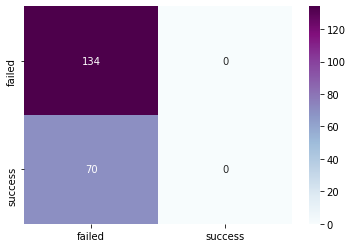

In [24]:
cm=confusion_matrix(test_y, y_pred)
sns.heatmap(cm,cmap='BuPu',annot=True,fmt='d', xticklabels=['failed', 'success'], yticklabels=['failed', 'success'])

In [25]:
print('******** LR **********')
print('Precision Score: ',precision_score(test_y,y_pred))
print('Recall Score: ',recall_score(test_y,y_pred))
print('Accuracy Score: ',accuracy_score(test_y,y_pred))
print('***********************')

******** LR **********
Precision Score:  0.0
Recall Score:  0.0
Accuracy Score:  0.6568627450980392
***********************


### Cross validation

In [126]:

modelCV = LogisticRegressionCV(Cs=2, fit_intercept=True, scoring=None, solver='sag', tol=0.0001, 
                                          max_iter=100, class_weight=None)

modelCV.fit(train_y, train_y)
y_pred = modelCV.predict(test_X)
accuracy = accuracy_score(test_y, y_pred)
print('******** LR **********')
print('Precision Score: ',precision_score(test_y,y_pred))
print('Recall Score: ',recall_score(test_y,y_pred))
print('Accuracy Score: ',accuracy_score(test_y,y_pred))
print('***********************')

******** LR **********
Precision Score:  0.4470588235294118
Recall Score:  0.5428571428571428
Accuracy Score:  0.6127450980392157
********************************************


### Try undersampling instead

In [127]:
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import NearMiss
undersample = NearMiss()

X_under, y_under = undersample.fit_resample(train_X, train_y)
Counter(y_under)

Counter({0: 281, 1: 281})

In [128]:

modelCV = LogisticRegressionCV(Cs=2, fit_intercept=True, scoring=None, solver='sag', tol=0.0001, 
                                          max_iter=100, class_weight=None)

modelCV.fit(X_under, y_under)
y_pred = modelCV.predict(test_X)
accuracy = accuracy_score(test_y, y_pred)
print('******** LR **********')
print('Precision Score: ',precision_score(test_y,y_pred))
print('Recall Score: ',recall_score(test_y,y_pred))
print('Accuracy Score: ',accuracy_score(test_y,y_pred))
print('***********************')

******** LR **********
Precision Score:  0.4838709677419355
Recall Score:  0.6428571428571429
Accuracy Score:  0.6421568627450981
********************************************


<AxesSubplot:>

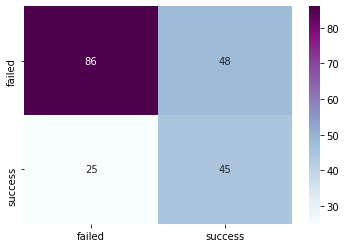

In [129]:
cm=confusion_matrix(test_y, y_pred)
sns.heatmap(cm,cmap='BuPu',annot=True,fmt='d', xticklabels=['failed', 'success'], yticklabels=['failed', 'success'])

undersampling yields slightly better performance compared to oversampling 

if given more time, I could have explored ensemble models or more advanced machine learning models but I chose LR since I am most familar with it and tree based models were yielding not the best results when I tried trainig them

## Serialize model

In [114]:
from pickle import dump

dump(modelCV, open('models/cross_model.pkl', 'wb'))